# Preparation

[View in Colaboratory](https://colab.research.google.com/github/stikbuf/Language_Modeling/blob/master/Keras_Character_Aware_Neural_Language_Models.ipynb)

## Configure the cloud environment


### Mount Google Drive

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# If you got a "Transport endpoint is not connected." error. Please run this line first to unmount the drive.
# See https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
!fusermount -u drive

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
a = !ls drive/
print('Files in Drive:', a)
assert a!=[], 'Drive should not be empty!'

In [ ]:
local_path='./drive/share_with_me/AI/Character-aware_LM/'
#local_path='./'
import sys
sys.path.append(local_path)
!ls './drive/share_with_me/AI/Character-aware_LM/'

In [ ]:
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "GPU not avaliable!"
tf.test.gpu_device_name()

## Load data (Penn Tree bank -- PTB)

In [1]:
local_path='./'

In [2]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Use single card. THIS LINE MUST BE RUN BEFORE TENSORFLOW IS IMPORTED
import pylab
%pylab inline
import matplotlib.pyplot as plt
import matplotlib  
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import random

from reader import ptb_raw_data, ptb_producer # by Google

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data(local_path + 'data') # tokens
id_to_word = dict((v, k) for k, v in word_to_id.items())
voc_size = len(id_to_word)
voc_size

10000

In [4]:
print('Train data size: {0}, Valid data size: {1}, Test data size: {2}\n'.
      format(len(train_data), len(valid_data), len(test_data)))
print('train/val/test_data is a list, some elements in train_data is', train_data[:10])

Train data size: 929589, Valid data size: 73760, Test data size: 82430

train/val/test_data is a list, some elements in train_data is [9970, 9971, 9972, 9974, 9975, 9976, 9980, 9981, 9982, 9983]


In [5]:
id_to_word[voc_size]='<SS>' # Add start word token '<SS>'
id_to_word[voc_size+1]='<EE>' # Add end word token '<EE>'
word_to_id = dict((v, k) for k, v in id_to_word.items())
voc_size = len(id_to_word)
voc_size

10002

In [6]:
word_id = pd.DataFrame.from_dict(word_to_id, orient='index').sort_values(by=0, ascending=True)
word_id.columns = ['id']
print(word_id.head())
print(word_id.tail())

       id
the     0
<unk>   1
<eos>   2
N       3
of      4
              id
ssangyong   9997
swapo       9998
wachter     9999
<SS>       10000
<EE>       10001


In [7]:
id_word = pd.DataFrame.from_dict(id_to_word, orient='index')
id_word.columns = ['word']
print(id_word.head())
print(id_word.tail())

    word
0    the
1  <unk>
2  <eos>
3      N
4     of
            word
9997   ssangyong
9998       swapo
9999     wachter
10000       <SS>
10001       <EE>


In [8]:
' '.join([id_to_word[id] for id in train_data[:50]])

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch'

In [9]:
seq_len = 35

# RNN baseline

## data generator

In [ ]:
import random

from tensorflow.python.keras.utils import to_categorical 

def gen_word_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<SS>']] + data[i:i+seq_len] + [word_to_id['<EE>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            #print(X.shape)
            cnt += batch_size
            yield X, Y

## Keras model

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Dense, Embedding, InputLayer, Dropout
from tensorflow.python.keras.optimizers import RMSprop

Add dropout between layers, see [Recurrent Neural Network Regularization](https://arxiv.org/abs/1409.2329)

In [ ]:
model = Sequential()

embedding_size = 128


model.add(Embedding(input_dim=voc_size,
                    output_dim=embedding_size,
                    name='inputEmbedding'))
model.add(GRU(units=128, return_sequences=True))
model.add(Dropout(0.3)) 
model.add(GRU(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(voc_size, activation='softmax'))

If we denote $w_{1:T} = [w_1, w_2,...,w_T ]$ to be the sequence of words in thes, training involves minimizing
the negative log-likelihood ($NLL$)
$$NLL = - \sum_{t=1}^{T} \log Pr (w_t | w_{1:t-1})$$
i.e. the Crossentropy loss (with out averaging).  
As is standard in language modeling, we use perplexity(PPL) to evaluate the performance of our models. Perplexity of a model over a sequence $[w_1, w_2,...,w_T ]$ is given by
$$PPL = e^\frac{NLL}{T} = e^{ave (Crossentropy)}$$
where $NLL/Crossentropy$ is calculated over the test set.


In [ ]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [ ]:
optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[ACC, PPL])

In [ ]:
model.summary()

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
import os
if not os.path.exists(local_path + 'model/'):
    os.mkdir(local_path + 'model/')

path_model = local_path + 'model/model.keras'    
tensorboard = TensorBoard(log_dir='log')
checkpoint = ModelCheckpoint(filepath=path_model, verbose=1,
                             monitor='val_PPL',mode='min' ,save_best_only='True')
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

callback_lists=[tensorboard,checkpoint]

In [ ]:
history = model.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=125,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

In [ ]:
logs = pd.DataFrame(history.history)

In [ ]:
print(logs.columns)
pylab.rcParams['figure.figsize'] = (13, 8)
logs.loc[1:,['PPL','val_PPL']].plot() # start with 1 makes the figure prettier

In [ ]:
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

In [ ]:
from tensorflow.python.keras.models import load_model

model_restore = load_model(path_model, custom_objects={'ACC':ACC,'PPL': PPL})

In [ ]:
history = model_restore.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=3,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

In [ ]:
logs = pd.DataFrame(history.history)
print(logs.columns)
pylab.rcParams['figure.figsize'] = (13, 8)
logs.loc[:,['PPL','val_PPL']].plot()

In [ ]:
def predict_seq(model, preSeq=None, genLen=seq_len, power=1):
    """ Predict a sequence with length genLen.
        arg:
            model: Keras model used to predict.
            preSeq: list. The leading sequence.
            genLen: float or np.inf. If power is equal to np.inf, then an argmax will be used. 
            power: Probility power.
    """
    preSeq = [word_to_id['<SS>']] if preSeq == None else [word_to_id['<SS>']] + preSeq   
    pointer = len(preSeq) - 1
    
    for _ in range(genLen):
        inputSeq = np.array([preSeq])
        prob = model.predict(inputSeq)[0, pointer, :]
        if power==np.inf:
            pred = np.argmax(prob)
        else:
            prob = np.power(prob, power)
            prob = prob / np.sum(prob)
            pred = np.random.choice(range(voc_size), p=prob)
        preSeq.append(pred)
        pointer = pointer + 1

    return preSeq, ' '.join([id_to_word[id] for id in preSeq])

In [ ]:
_, seq = predict_seq(model, power=1)
seq

# Character aware model

[Character-Aware Neural Language Models -- arxiv-1508.06615 -- AAAI 2016](https://arxiv.org/abs/1508.06615)

[Ref: Github/jarfo/kchar](https://github.com/jarfo/kchar)


![model](https://github.com/stikbuf/Language_Modeling/blob/master/Character%20aware.png?raw=true)


## Load data

### convert to text

Text(0.5,1,'word length distribution, max=19, min=1')

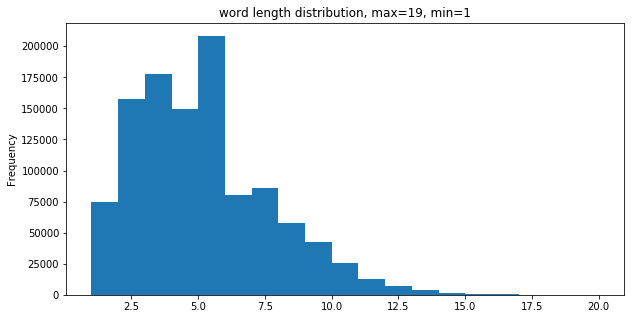

In [10]:
train_data_text = [id_to_word[idx] for idx in train_data]
valid_data_text = [id_to_word[idx] for idx in valid_data]
test_data_text = [id_to_word[idx] for idx in test_data]
total_data_text = train_data_text + valid_data_text + test_data_text

maxWordLen = max([len(word) for word in total_data_text])
maxWordLen += 2 # Inclued Start and End character

ds = pd.Series([len(word) for word in total_data_text])
plt.figure(figsize=(10,5))
ds.plot.hist(bins=range(1, maxWordLen))
plt.title('word length distribution, max={0}, min={1}'.
          format(ds.max(), ds.min()))

### merge chars

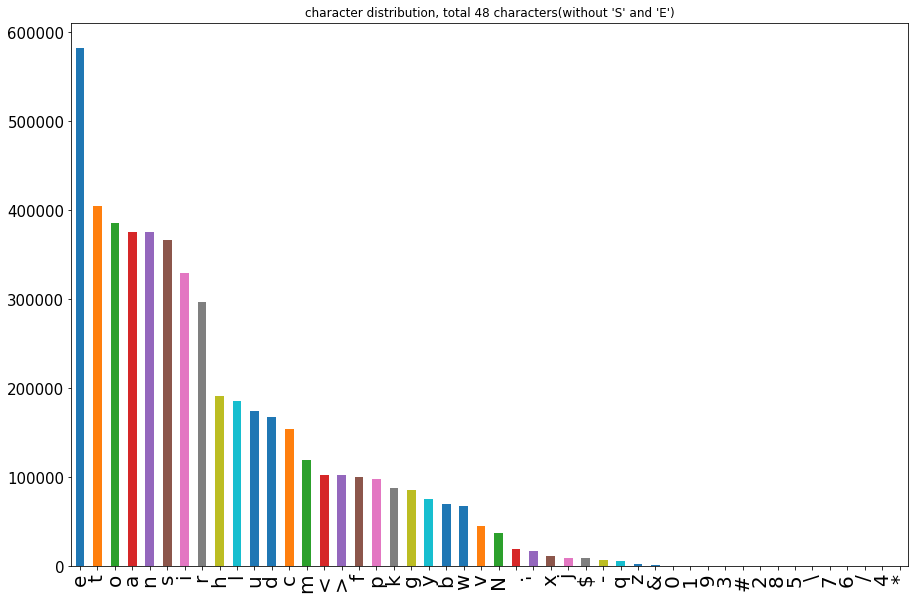

number of chars: 51 

['0', 'j', 'S', '\\', '1', 's', '7', 'b', '-', 'o', 'c', "'", '/', '&', 'g', '2', 'a', 'p', 'e', '4', 'z', '9', 'v', '6', '.', 'N', 'n', 'r', 't', 'd', 'l', 'h', 'q', '5', 'u', '#', '8', 'E', 'k', 'y', '*', ' ', 'x', '3', 'f', '>', 'i', 'm', '$', 'w', '<'] 

{0: '0', 1: 'j', 2: 'S', 3: '\\', 4: '1', 5: 's', 6: '7', 7: 'b', 8: '-', 9: 'o', 10: 'c', 11: "'", 12: '/', 13: '&', 14: 'g', 15: '2', 16: 'a', 17: 'p', 18: 'e', 19: '4', 20: 'z', 21: '9', 22: 'v', 23: '6', 24: '.', 25: 'N', 26: 'n', 27: 'r', 28: 't', 29: 'd', 30: 'l', 31: 'h', 32: 'q', 33: '5', 34: 'u', 35: '#', 36: '8', 37: 'E', 38: 'k', 39: 'y', 40: '*', 41: ' ', 42: 'x', 43: '3', 44: 'f', 45: '>', 46: 'i', 47: 'm', 48: '$', 49: 'w', 50: '<'} 

{'0': 0, 'j': 1, 'S': 2, '\\': 3, '1': 4, '/': 12, '7': 6, 'b': 7, 'o': 9, "'": 11, '&': 13, 'g': 14, '#': 35, ' ': 41, '2': 15, 'u': 34, 'a': 16, 'p': 17, '4': 19, 'z': 20, '9': 21, 'e': 18, 'v': 22, '6': 23, '.': 24, 'N': 25, 'n': 26, 'r': 27, 't': 28, 'd': 29, 'l

In [11]:
chars = []
for word in total_data_text:
    chars.extend(list(word))
    
ds = pd.Series(chars)
plt.figure(figsize=(15,10))   
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=15)
ds.value_counts().plot.bar()
plt.title('character distribution, total {0} characters(without \'S\' and \'E\')'.format(len(set(chars))))
plt.show()

chars = list(set(chars + ['S'] + ['E'] + [' ']))
# 'S' for word leading char, 'E' for word ending char, space for padding
id_to_chars = dict(enumerate(chars))
chars_to_id = dict((v, k) for k,v in id_to_chars.items())
num_chars = len(chars)

print('number of chars:', num_chars, '\n')
print(chars, '\n')
print(id_to_chars, '\n')
print(chars_to_id, '\n')

In [12]:
def word_to_charId(wordId):
    # Convert word to a string of word Ids
    wordString = 'S' + id_to_word[wordId].center(maxWordLen - 2) + 'E'
    return [chars_to_id[char] for char in wordString]

def wordSeq_charSeq(bWordSeq):
    batch, seqLen = bWordSeq.shape
    bWordSeq = bWordSeq.ravel()
    charSeq = np.array([word_to_charId(wordId) for wordId in bWordSeq])
    return charSeq.reshape(batch, seqLen, -1)

word_to_charId(word_to_id['the']) # 

[2,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 28,
 31,
 18,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 41,
 37]

In [13]:
import random

from tensorflow.python.keras.utils import to_categorical 

def gen_char_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<SS>']] + data[i:i+seq_len] + [word_to_id['<EE>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            X = wordSeq_charSeq(X) 
            #print(X.shape)
            cnt += batch_size
            yield X, Y

In [14]:
print(next(gen_char_word(batch_size=1, dataset='train'))[1][0][2].shape)

(10002,)


## option

In [15]:
class Option():
    def __init__(self):
        self.batch_size = 20
        self.seq_length = seq_len + 1
        self.max_word_l = maxWordLen # Include Start and End character
        self.char_vocab_size = num_chars
        self.char_vec_size = 15
        self.feature_maps = [50,100,150,200,200,200,200]
        self.kernels = [1,2,3,4,5,6,7]
        self.highway_layers = 2
        self.num_lstm_layers = 2
        self.rnn_size = 128
        self.word_vocab_size = voc_size
        self.dropout = 0.5
        self.learing_rate = 1e-5
        
opt = Option()

## CNN
![CNN part](https://github.com/stikbuf/Language_Modeling/blob/master/Character%20aware-CNN.png?raw=true)

In [16]:
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Concatenate, Reshape

def CNN(seq_length, length, feature_maps, kernels, x):

    concat_input = []
    for feature_map, kernel in zip(feature_maps, kernels):
        reduced_l = length - kernel + 1
        conv = Conv2D(feature_map, (1, kernel), activation='tanh', data_format="channels_last")(x)
        maxp = MaxPooling2D((1, reduced_l), data_format="channels_last")(conv)
        concat_input.append(maxp)

    x = Concatenate()(concat_input)
    x = Reshape((seq_length, sum(feature_maps)))(x)
    return x

## Highway Network  
[Srivastava et al.](https://arxiv.org/abs/1505.00387)

Input vector is $\textbf{y}$, then layer output $\textbf{z}$ is
$$\textbf{z = t} \odot g(\textbf{W}_H\textbf{y}+\textbf{b}_H) + \textbf{(1 - t)} \odot \textbf{y}$$
where 
$$\textbf{t} = \sigma(\textbf{W}_T\textbf{y}+\textbf{b}_T)$$

$\textbf{t}$ is called the
*transform gate*, and $(\textbf{1}−\textbf{t})$ is called the *carry gate*. 
Similar to the memory cells in LSTM networks, highway layers allow for training of deep networks by adaptively carrying some dimensions of the input directly to the output. By construction the dimensions of $\textbf{y}$ and $\textbf{z}$ have to match, and hence $\textbf{W}_T$ and $\textbf{W}_H$ are square matrices. **Basically, a highway layer is a dense layer with residual connection modulated by an adaptive gate.**

A keras model is also a keras layer! So you can combine some keras layers to design your own layer. This is useful when combining with TimeDistributed wrapper. [See section 3 in this blog](https://keunwoochoi.wordpress.com/2016/11/18/for-beginners-writing-a-custom-keras-layer/)

In [17]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Dense, Activation, Multiply, Add, Lambda, Input
from tensorflow.python.keras.initializers import Constant
from tensorflow.python.keras.models import Model

class LambdaWithShape(Lambda):
#     def __init__(self, function, **kwargs):
#         super(LambdaWithShape, self).__init__(function, **kwargs)
    def compute_output_shape(self, input_shape):
        return input_shape

def Highway(value, nLayers, activation='tanh', gateBias=-3):
    dim = K.int_shape(value)[-1]
    gateBiasInitalizer = Constant(gateBias)
    for i in range(nLayers):
        tGate = Dense(units=dim, bias_initializer=gateBiasInitalizer)(value)
        tGate = Activation('sigmoid')(tGate)
        #cGate = Lambda(lambda x: 1.0-x)(tGate) # WARNING:tensorflow:All custom layers should implement the `compute_output_shape`
        cGate = LambdaWithShape(lambda x: 1.0-x)(tGate) # I do not specify output_shape
        transformed = Dense(units=dim, bias_initializer=gateBiasInitalizer)(value)
        transformed = Activation(activation)(value)
        transformedGate = Multiply()([tGate, transformed])
        identityGate = Multiply()([cGate, value])
        value = Add()([transformedGate, identityGate])
    return value

inputs = Input((sum(opt.feature_maps),))
HighwayLayer = Model(inputs=inputs, outputs=Highway(inputs, nLayers=opt.highway_layers))

## Model

In [18]:
from tensorflow.python.keras.layers import Input, Embedding, GRU, Dropout, BatchNormalization, TimeDistributed
#from tensorflow.python.keras.optimizers import SGD

#chars = Input(batch_shape=(opt.batch_size, opt.seq_length, opt.max_word_l), name='chars')
chars = Input(shape=(opt.seq_length, opt.max_word_l), name='chars') # will get a warning if you do not specify batch_shape
chars_embedding = Embedding(opt.char_vocab_size, opt.char_vec_size, name='chars_embedding')(chars)
cnn = CNN(opt.seq_length, opt.max_word_l, opt.feature_maps, opt.kernels, chars_embedding)
x = cnn
inputs = chars

x = BatchNormalization()(x)

x = TimeDistributed(HighwayLayer)(x)
highway = x

for l in range(opt.num_lstm_layers):
    #x = GRU(opt.rnn_size, return_sequences=True, stateful=True)(x)
    x = GRU(opt.rnn_size, return_sequences=True, stateful=False)(x)

    if opt.dropout > 0:
        x = Dropout(opt.dropout)(x)
        
output = Dense(opt.word_vocab_size, activation='softmax')(x)

modelCAware = Model(inputs=inputs, outputs=output)
modelCAware.summary()    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chars (InputLayer)              (None, 36, 21)       0                                            
__________________________________________________________________________________________________
chars_embedding (Embedding)     (None, 36, 21, 15)   765         chars[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 21, 50)   800         chars_embedding[0][0]            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 20, 100)  3100        chars_embedding[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

In [19]:
modelConvWordFeatureBeforeHighway = Model(inputs=inputs, outputs=cnn)
modelConvWordFeatureAfterHighway = Model(inputs=inputs, outputs=highway)

In [20]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [21]:
from tensorflow.python.keras.optimizers import RMSprop

optimizer = RMSprop(lr=opt.learing_rate)
modelCAware.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=[ACC, PPL])  

In [22]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
import os
if not os.path.exists(local_path + 'model/'):
    os.mkdir(local_path + 'model/')

path_model = local_path + 'model/modelAware.keras'    
tensorboard = TensorBoard(log_dir='log')
checkpoint = ModelCheckpoint(filepath=path_model, verbose=1,
                             monitor='val_PPL',mode='min' ,save_best_only='True')
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

callback_lists=[tensorboard,checkpoint]

In [25]:
history = modelCAware.fit_generator(generator=gen_char_word(batch_size=opt.batch_size), 
                           steps_per_epoch=50, epochs=5,
                           callbacks=callback_lists,
                           validation_data=gen_char_word(batch_size=opt.batch_size, dataset='valid'),
                           validation_steps=30)

Epoch 1/5
49/50 [============================>.] - ETA: 0s - loss: 6.1494 - ACC: 0.1290 - PPL: 471.9566
Epoch 00001: val_PPL did not improve
50/50 [==============================] - 18s 352ms/step - loss: 6.1472 - ACC: 0.1294 - PPL: 470.8961 - val_loss: 6.0471 - val_ACC: 0.1348 - val_PPL: 425.8689
Epoch 2/5
49/50 [============================>.] - ETA: 0s - loss: 6.1069 - ACC: 0.1306 - PPL: 454.4035
Epoch 00002: val_PPL did not improve
50/50 [==============================] - 14s 277ms/step - loss: 6.1064 - ACC: 0.1308 - PPL: 454.0947 - val_loss: 6.0253 - val_ACC: 0.1312 - val_PPL: 416.7355
Epoch 3/5
49/50 [============================>.] - ETA: 0s - loss: 6.1185 - ACC: 0.1374 - PPL: 459.0193
Epoch 00003: val_PPL improved from 405.92758 to 404.76979, saving model to ./model/modelAware.keras
50/50 [==============================] - 14s 279ms/step - loss: 6.1133 - ACC: 0.1377 - PPL: 456.8452 - val_loss: 5.9921 - val_ACC: 0.1351 - val_PPL: 404.7698
Epoch 4/5
49/50 [=======================

Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


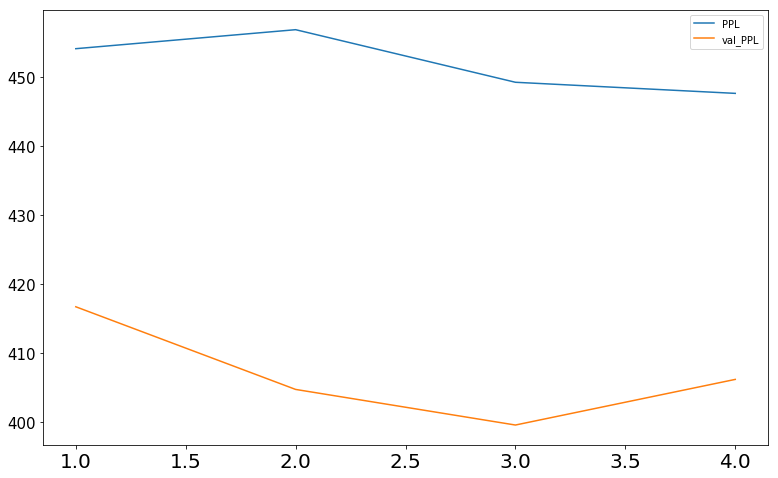

In [26]:
logs = pd.DataFrame(history.history)
print(logs.columns)
pylab.rcParams['figure.figsize'] = (13, 8)
logs.loc[1:,['PPL','val_PPL']].plot()
plt.show()

## Word feature analysis
The convolution and the highway network can be viewed as a word feature extractor. Let's establish some intuition by the following experiments.

In [27]:
def extractWordFeature(words, extcModel=modelConvWordFeatureAfterHighway):
    """
    words: List of word text.
    extcModel: Extractor model.
    
    returns: Pandas dataframe. Index is the word, corresponding to the feature vector.
    """
    
    padWord = lambda word: 'S' + word.lower().center(opt.max_word_l - 2) + 'E' # pad a single word
    wordsPadedCroped = [padWord(word[:opt.max_word_l-2]) for word in words] # cut input word if it is too long
    #print(wordsPadedCroped)
    wordsPadedCroped = [[chars_to_id[char] for char in word] for word in wordsPadedCroped] # convert to char index
    #print(wordsPadedCroped)
    
    # split into batches, list of tuples
    batches = []
    while wordsPadedCroped != []:
        if len(wordsPadedCroped)>opt.seq_length:
            batches.append((np.array(wordsPadedCroped[:opt.seq_length]), opt.seq_length))
            wordsPadedCroped = wordsPadedCroped[opt.seq_length:]
        else:
            wLast = wordsPadedCroped + [[chars_to_id[' ']]*opt.max_word_l]*(opt.seq_length-len(wordsPadedCroped))         
            batches.append((np.array(wLast), len(wordsPadedCroped)))
            wordsPadedCroped = []   
    
    features = []
    for batch in batches:
        data = batch[0]
        validNum = batch[1]
        features.append(extcModel.predict(np.expand_dims(data,0))[0,:validNum,:])
    
    features = np.vstack(features)
    
    # return a dataframe
    features = pd.DataFrame(data=features, index=words)
    features.index.name = 'featVecs'
    features.columns.name = 'vecDims'
    
    return features

In [29]:
sampleWordList = ['look','looks','looked','looking','lok','looooooook',
                  'lk','loop','lock','locked','cook','see','observation',
                  'hear','run','reading','news','book','computer',
                  'programming','python','java','lisp','c#','matlab','jupyter']
vocWordList = list(word_id.index)
print(vocWordList[:5], '......', vocWordList[-4:])

['the', '<unk>', '<eos>', 'N', 'of'] ...... ['swapo', 'wachter', '<SS>', '<EE>']


In [35]:
from scipy.spatial.distance import cdist

def sortedWordsByDistance(queryWord, Words, metric='cosine', 
                          extcModel=modelConvWordFeatureBeforeHighway):
    """
    queryWord: Single query word
    Words: Words to compare
    metric: metrics -- 'cosine',euclidean','correlation',...
    """
    queryWordFeat = extractWordFeature([queryWord], extcModel=extcModel)
    wordFeats = extractWordFeature(Words, extcModel=extcModel) 
    
    dis = pd.Series(cdist(queryWordFeat, wordFeats, metric=metric)[0])
    dis.index = Words
    dis = dis.sort_values(ascending=True)
    return dis
    
    
sortedDis = sortedWordsByDistance('look', sampleWordList)
sortedDis

look           2.220446e-16
looooooook     8.282100e-03
lock           8.606353e-03
lok            1.313374e-02
looks          1.584342e-02
loop           1.630633e-02
cook           1.979003e-02
book           2.084236e-02
lk             2.467644e-02
looked         2.822085e-02
locked         3.151691e-02
looking        3.182682e-02
c#             4.086795e-02
hear           4.378698e-02
lisp           4.382751e-02
python         4.863239e-02
see            4.977712e-02
matlab         5.130703e-02
run            5.190877e-02
news           5.304116e-02
java           5.439117e-02
computer       5.884274e-02
reading        6.188160e-02
observation    6.330222e-02
jupyter        6.520263e-02
programming    6.830563e-02
dtype: float64

In [37]:
smpFeatures = extractWordFeature(sampleWordList, extcModel=modelConvWordFeatureAfterHighway)
smpFeatures

vecDims,0,1,2,3,4,5,6,7,8,9,...,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099
featVecs,,,,,,,,,,,,,,,,,,,,,
look,-0.474346,0.280366,-0.112173,-0.637157,0.474413,-0.569973,-0.863466,1.960903,-0.404472,0.743962,...,-0.628928,1.761515,-0.031091,-0.719275,1.472765,-0.504468,-1.327713,-0.453188,-0.711252,1.724883
looks,-0.448740,0.280347,-0.112107,-0.637294,0.465791,-0.559033,-0.513758,1.954690,-0.402920,0.701793,...,-0.522337,0.995838,0.582233,-0.173730,1.177071,-0.521029,-1.304848,-0.451146,-0.003121,1.100584
looked,-0.464960,0.279495,-0.111919,-0.612333,0.465528,-0.127111,-0.083281,1.366130,-0.398013,0.676054,...,-0.417430,0.100187,0.975605,0.540303,1.098185,-0.527498,-1.240027,-0.340431,-0.239468,1.044662
looking,0.012201,0.280452,-0.111859,0.695795,0.457250,-0.507483,0.889052,0.864474,-0.398954,0.890458,...,-0.223665,0.911513,0.394047,0.487010,1.038142,0.292902,-1.303878,-0.431276,0.804085,-0.374267
lok,-0.475233,0.279977,-0.112168,-0.636935,0.475403,-0.570063,-0.937190,1.962843,-0.402309,0.742850,...,-0.796794,1.072365,0.497433,-0.279615,2.465507,0.180651,-1.223346,-0.452919,-1.234995,-0.098026
looooooook,-0.475440,0.280313,-0.112201,-0.636370,0.474308,-0.570470,-0.862713,1.962325,-0.403816,0.744490,...,-1.100772,1.093686,0.412321,0.652190,0.449645,0.059781,-1.327459,-0.453285,-1.148350,1.468859
lk,-0.478096,0.279760,-0.112236,-0.729230,0.476393,-0.570497,-0.975007,1.962988,-0.528013,0.743845,...,-0.915497,2.095476,-0.545157,0.231854,1.487033,-0.394246,-0.936405,-1.382721,-0.319436,-0.868755
loop,-0.469580,0.280368,-0.112165,0.138761,0.472585,-0.564050,0.090549,-0.601081,-0.404570,0.825027,...,-0.587063,2.021392,0.700883,0.173749,1.193119,0.026982,-1.018667,-0.452069,0.297451,1.195658
lock,-0.474649,0.280169,-0.112206,0.081162,0.474410,-0.356548,-0.923404,1.959710,-0.403920,0.741712,...,-0.653424,1.791219,-0.296539,-0.758791,1.410185,-0.218515,-1.336119,-0.452889,-0.584914,2.503913


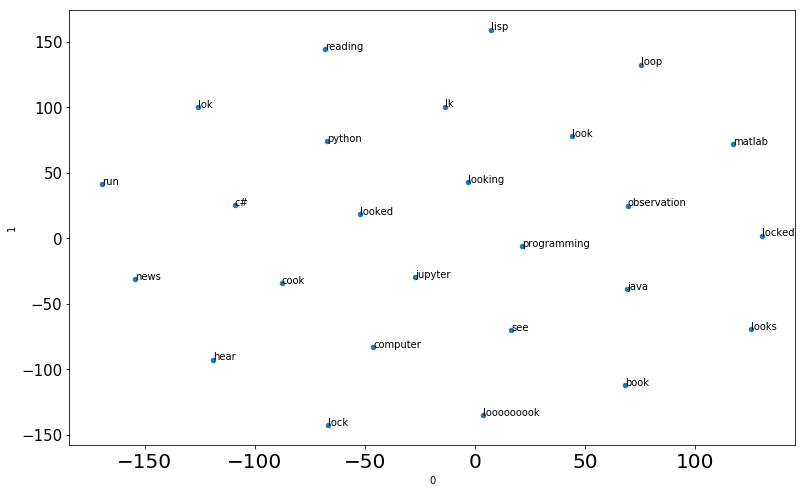

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def featureVis(feautres, usePCA=True):
    """
    features: A pandas dataframe. Index should be words, values should be word features.
    """
    wordList = feautres.index
    featTransed = feautres.values
    if usePCA:
        featTransed = PCA(n_components=len(feautres.columns)//7).fit_transform(featTransed)
    featTransed = TSNE(n_components=2).fit_transform(featTransed)
    featTransed = pd.DataFrame(featTransed, index=wordList)
    featTransed.index.name = 'featVecs'
    featTransed.columns.name = 'vecDims'

    pylab.rcParams['figure.figsize'] = (13, 8)
    axes = featTransed.plot.scatter(x=0, y=1)
    for txt in wordList:
        axes.annotate(txt, (featTransed.loc[txt,0],featTransed.loc[txt,1]))
        
featureVis(smpFeatures, usePCA=True)

In [42]:
vocFeatures = extractWordFeature(vocWordList, extcModel=modelConvWordFeatureAfterHighway)
vocFeatures.head(1000)

vecDims,0,1,2,3,4,5,6,7,8,9,...,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099
featVecs,,,,,,,,,,,,,,,,,,,,,
the,-0.476683,0.279939,0.883552,-0.900573,0.474653,-0.128126,-0.083363,-0.602580,-0.532572,-0.820463,...,-1.275292,0.246634,-1.031373,0.225956,1.725591,-0.869396,-0.381661,-1.335109,-1.251666,-0.816856
<unk>,0.066368,0.279573,-0.112148,0.852693,0.464948,-0.481629,0.894981,0.752132,0.756831,-0.364749,...,0.716718,0.606901,-0.310391,0.211778,1.149022,0.222030,0.831978,-0.424449,0.396979,0.827501
<eos>,-0.472406,0.279782,-0.112144,-0.151947,0.473129,-0.127760,0.924624,0.469898,0.757451,0.125385,...,0.761208,0.457401,0.339750,-0.456320,0.988040,0.637624,0.065307,0.352959,0.434467,1.465943
N,0.012201,0.273365,-0.112245,-0.454116,0.476622,-0.570613,0.282836,-0.602599,-0.515928,-2.377636,...,-1.326922,-0.608072,-0.396379,-0.342243,1.536497,-0.668287,-1.021301,-2.204404,-0.896322,-0.741156
of,2.332442,0.273851,-0.112236,-0.563221,0.476459,2.861319,-0.069748,-0.602600,-0.402783,-2.170480,...,-1.210165,-0.259445,-0.530075,-0.709163,1.523471,-0.621629,-0.949678,-1.786170,-0.964790,-0.749671
to,-0.478651,0.276170,-0.112201,-0.565394,0.476414,-0.570621,-0.780556,-0.602601,-0.404522,-0.821541,...,-1.399778,0.884153,-0.508405,0.068556,1.535575,-0.550205,-0.611957,-0.790551,-0.957045,-0.687772
a,-0.478596,0.273544,-0.112249,-0.722320,0.476625,-0.570622,-0.755917,-0.602601,-0.533921,-0.731719,...,-0.992986,-0.660352,-0.574720,0.104458,1.577960,-1.051796,-0.935002,-2.334825,-0.977312,-0.754415
in,0.012201,0.280069,-0.112243,-0.108110,0.474343,-0.565192,0.295829,-0.602558,-0.518628,0.994248,...,-0.686194,0.436696,-0.317058,0.829555,1.537400,-0.710117,0.563345,-1.022873,-0.597869,-0.445153
and,0.012201,0.279708,-0.112213,-0.479025,0.475536,-0.548974,0.298532,-0.497815,-0.527341,-0.278180,...,-0.576507,0.909953,0.893635,0.572710,1.463578,0.556239,-0.704390,-0.408391,1.234056,-0.470330


CPU times: user 8.23 s, sys: 6.21 s, total: 14.4 s
Wall time: 4.23 s


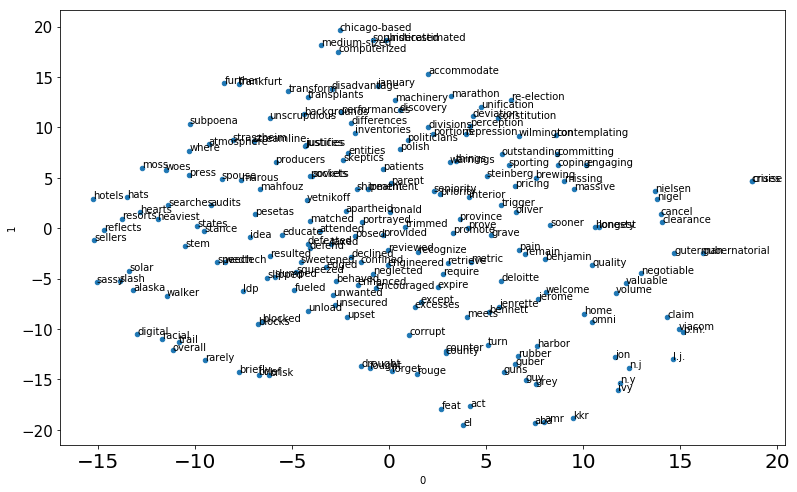

In [43]:
%%time
sample = vocFeatures.sample(200)
featureVis(sample, usePCA=True)